      country      q0  alloc_lp      choice  received  compensation
0   Country_1  131.90    131.90  compensate      0.00       118.710
1   Country_2  107.48    107.48  compensate      0.00        96.732
2   Country_3   69.20     69.20     project     34.60        27.680
3   Country_4   94.04     94.04  compensate      0.00        84.636
4   Country_5   91.56     91.56     project     45.78        36.624
5   Country_6   87.06     87.06     project     43.53        34.824
6   Country_7  104.93    104.93  compensate      0.00        94.437
7   Country_8   96.98     96.98  compensate      0.00        87.282
8   Country_9  118.00    118.00     project     59.00        47.200
9  Country_10   98.84     98.84  compensate      0.00        88.956


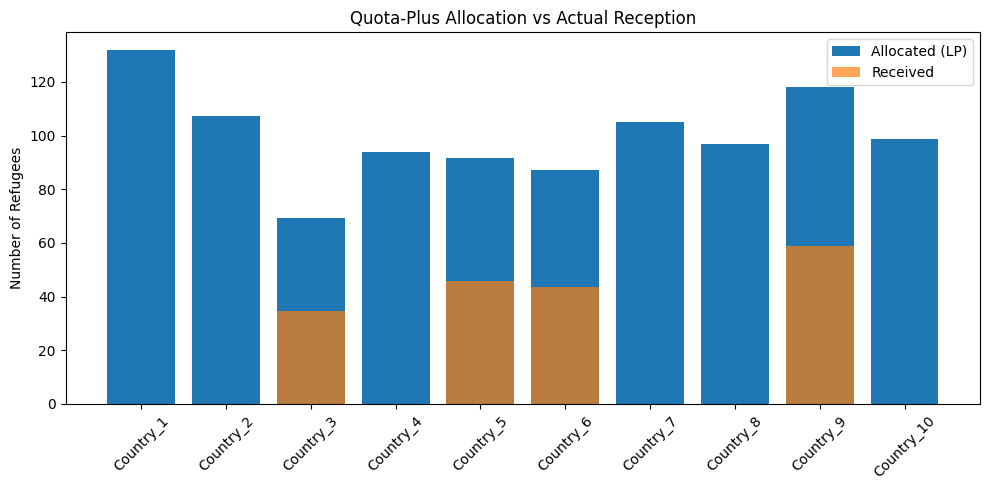

In [2]:
# ====== Install dependencies ======
!pip install cvxpy pandas matplotlib ecos

# ====== Import libraries ======
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

np.random.seed(206)  # for reproducibility

# ====== Parameters ======
N = 10  # number of countries
total_refugees = 1000
alpha, beta, gamma = 0.4, 0.4, 0.2  # weights: population, GDP, historical intake

# ====== Generate country features ======
pop = np.random.uniform(1, 50, N)
gdp = np.random.uniform(10, 500, N)
history = np.random.uniform(0, 200, N)
pc = np.random.uniform(50, 150, N)  # policy threshold for flexible compliance

df = pd.DataFrame({
    'country': [f'Country_{i+1}' for i in range(N)],
    'population': pop,
    'GDP': gdp,
    'history': history,
    'policy_threshold': pc
})

# ====== Compute shares (initial quotas) ======
df['pop_share'] = df['population'] / df['population'].sum()
df['GDP_share'] = df['GDP'] / df['GDP'].sum()
df['hist_share'] = df['history'] / df['history'].sum() if df['history'].sum() > 0 else 0

# Initial quota q0
q0 = alpha * df['pop_share'] + beta * df['GDP_share'] + gamma * df['hist_share']
q0 = q0 / q0.sum() * total_refugees
df['q0'] = np.round(q0, 2)

# ====== Linear programming optimization (Quota-Plus) ======
# Mathematical model:
# min t
# s.t. x >= 0, sum(x) = total_refugees
#      |x_i - q0_i| <= t  for all i

x = cp.Variable(N)
t = cp.Variable(1)
constraints = [x >= 0, cp.sum(x) == total_refugees]

for i in range(N):
    constraints += [x[i] - q0.iloc[i] <= t, q0.iloc[i] - x[i] <= t]

prob = cp.Problem(cp.Minimize(t), constraints)

try:
    prob.solve(solver=cp.ECOS)  # try ECOS solver
except cp.SolverError:
    prob.solve()  # fallback: automatic solver selection

df['alloc_lp'] = np.round(x.value, 2)

# ====== Flexible compliance strategy (Quota-Plus) ======
# Vectorized assignment:
df['received'] = np.where(
    df['alloc_lp'] <= df['history']*0.5, df['alloc_lp'],
    np.where(df['alloc_lp'] > df['policy_threshold'], 0, df['alloc_lp']*0.5)
)
df['compensation'] = np.where(
    df['alloc_lp'] <= df['history']*0.5, 0,
    np.where(df['alloc_lp'] > df['policy_threshold'], df['alloc_lp']*0.9, df['alloc_lp']*0.4)
)
df['choice'] = np.where(
    df['alloc_lp'] <= df['history']*0.5, 'accept',
    np.where(df['alloc_lp'] > df['policy_threshold'], 'compensate', 'project')
)

# ====== Display results ======
print(df[['country','q0','alloc_lp','choice','received','compensation']])

# ====== Visualization ======
plt.figure(figsize=(10,5))
plt.bar(df['country'], df['alloc_lp'], label='Allocated (LP)')
plt.bar(df['country'], df['received'], label='Received', alpha=0.7)
plt.ylabel("Number of Refugees")
plt.xticks(rotation=45)
plt.legend()
plt.title("Quota-Plus Allocation vs Actual Reception")
plt.tight_layout()
plt.show()
